## Wake County - Restaurant Food Inspections Analysis

In [114]:
# import pandas, numpy, matplotlib, seaborn 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# importing the requests library
import requests
import json

# importing sklearn library for data pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression, f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_squared_error, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOTClassifier

In [2]:
# !pip install ipynb
!pip install tpot

### Resources
 1. [Restaurants in Wake County Data Info](https://www.arcgis.com/home/item.html?id=124c2187da8c41c59bde04fa67eb2872)
 2. [Wake County Open Data](https://data-wake.opendata.arcgis.com/search?tags=restaurants)
 3. [Food Inspection Violations Data Info](https://data.wakegov.com/datasets/Wake::food-inspection-violations/about)
 4. [Wake County Yelp Initiative](https://ash.harvard.edu/news/wake-county-yelp-initiative)
 5. [Yelp LIVES data](https://www.yelp.com/healthscores/feeds)

We're sourcing and pre-processing all the data in other notebooks. We have saved the pre-processed data in csv files so we can load them into dataframes in our main file here.
If you do want to source them from here, you're free to do so just uncomment the imports above so you can use the functions from the other notebooks. 

## Fetch Restaurant Inspections

In [4]:
inspectionsdf = pd.read_csv('preprocessed_inspections.csv')
print(inspectionsdf.shape)
inspectionsdf.head()

(27343, 8)


,OBJECTID,HSISID,SCORE,DATE,DESCRIPTION,TYPE,INSPECTOR,PERMITID
0,22236469,4092017542,95.0,2018-03-23,NaN,Inspection,Laura McNeill,367
1,22236470,4092017542,93.5,2018-09-07,"*NOTICE* EFFECTIVE JANUARY 1, 2019, THE NC FOO...",Inspection,Laura McNeill,367
2,22236471,4092017542,93.0,2019-04-04,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Joanne Rutkofske,367
3,22236472,4092017542,93.5,2019-10-07,Follow-Up: 10/17/2019,Inspection,Naterra McQueen,367
4,22236473,4092017542,92.5,2020-05-19,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Naterra McQueen,367


## Fetch Restaurant Data 

In [5]:
restaurantsdf = pd.read_csv('preprocessed_restaurants.csv')
print(restaurantsdf.shape)
restaurantsdf.head()

(2385, 12)


,OBJECTID,HSISID,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,PERMITID,X,Y,GEOCODESTATUS
0,1891530,4092016487,PEACE CHINA,13220 Strickland RD,RALEIGH,27613,1.919677e+10,2013-08-14,2,-78.725938,35.908783,M
1,1891531,4092018622,Northside Bistro & Cocktails,832 SPRING FOREST RD,RALEIGH,27609,1.919891e+10,2021-05-13,22,-78.622635,35.866275,M
2,1891532,4092016155,DAILY PLANET CAFE,11 W JONES ST,RALEIGH,27601,1.919708e+10,2012-04-12,26,-78.639431,35.782205,M
3,1891533,4092016161,HIBACHI 88,3416 POOLE RD,RALEIGH,27610,1.919231e+10,2012-04-18,28,-78.579533,35.767246,M
4,1891534,4092017180,BOND BROTHERS BEER COMPANY,202 E CEDAR ST,CARY,27511,1.919459e+10,2016-03-11,29,-78.778021,35.787986,M


## Fetch violations

In [6]:
violationsdf = pd.read_csv('preprocessed_violations.csv')
print(violationsdf.shape)
violationsdf.head()

(178102, 15)


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,QUESTIONNO,VIOLATIONCODE,SEVERITY,SHORTDESC,INSPECTEDBY,COMMENTS,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE,CDCDATAITEM
0,188572810,4092017322,2020-07-10,Approved Source,NaN,9,3-201.11,NaN,Food obtained from approved source,Lauren Harden,3-201.11; PIC states that bakery items in disp...,0.0,OUT,NaN,Food shall be obtained from sources that compl...
1,188572819,4092110520,2018-03-05,Approved Source,NaN,10,3-202.11,NaN,Food received at proper temperature,Laura McNeill,3-202.11; pans of reheated beef steak received...,1.0,OUT,CDI,Refrigerated food shall be at a temperature of...
2,188572820,4092017143,2018-08-20,Approved Source,NaN,10,3-202.11,NaN,Food received at proper temperature,Jennifer Brown,3-202.11;Measured raw shell eggs at 49-50F upo...,0.0,OUT,CDI,Refrigerated food shall be at a temperature of...
3,188572821,4092110158,2019-02-20,Approved Source,NaN,10,3-202.11,NaN,Food received at proper temperature,Kaitlyn Yow,3-202.11;,0.0,N/O,NaN,Refrigerated food shall be at a temperature of...
4,188572822,4092014259,2019-09-23,Approved Source,NaN,10,3-202.11,NaN,Food received at proper temperature,Laura McNeill,3-202.11; upon arrival the manager had receive...,0.0,OUT,NaN,Refrigerated food shall be at a temperature of...


## Fetch weather data

In [7]:
# weatherdata_raw = getWeatherData()
# weatherdata = preprocess_weatherdata(weatherdata_raw.copy())
weatherdatadf = pd.read_csv('preprocessed_weatherdata.csv')
print(weatherdatadf.shape)
weatherdatadf.head()

(1406, 2)


,date,TAVG
0,2018-01-01,22.0
1,2018-01-02,20.0
2,2018-01-03,21.0
3,2018-01-04,26.0
4,2018-01-05,21.0


## Fetch Yelp Ratings Data

In [9]:
def getTitle(category_json):
    try:
        return json.loads(category_json[1:-1])[0]['title']
    except:
        return ""

# read in yelp and restaurant data

yelpdatadf = pd.read_csv('preprocessed_yelpdata.csv')
print(yelpdatadf.shape)

# extract category title out of the alias/categories json
yelpdatadf['alias'] = yelpdatadf['categories'].apply(lambda x: str(json.dumps(x)))
yelpdatadf['alias'] = yelpdatadf['alias'].apply(lambda x: x.replace("\'", "\"").strip())
yelpdatadf['category_title'] = yelpdatadf['alias'].apply(lambda x: getTitle(x).lower())
display(yelpdatadf.head())

(2145, 9)


,name,is_closed,review_count,categories,rating,price,location,phone,display_phone,alias,category_title
0,Peace China,True,63,"[{'alias': 'chinese', 'title': 'Chinese'}]",3.5,$,"{'address1': '13220 Strickland Rd', 'address2'...",19196769968,(919) 676-9968,"""[{""alias"": ""chinese"", ""title"": ""Chinese""}]""",chinese
1,Asian Cafe,True,7,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",3.0,$$,"{'address1': '13220 Strickland Rd', 'address2'...",19196769968,(919) 676-9968,"""[{""alias"": ""chinese"", ""title"": ""Chinese""}, {""...",chinese
2,Northside Bistro & Cocktails,False,23,"[{'alias': 'newamerican', 'title': 'American (...",4.5,NaN,"{'address1': '832 Spring Forest Rd', 'address2...",19198905225,(919) 890-5225,"""[{""alias"": ""newamerican"", ""title"": ""American ...",american (new)
3,The Daily Planet Cafe,False,89,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.0,$$,"{'address1': '121 W Jones St', 'address2': '',...",19197078060,(919) 707-8060,"""[{""alias"": ""cafes"", ""title"": ""Cafes""}, {""alia...",cafes
4,Hibachi 88,False,46,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",3.5,$,"{'address1': '3416-100 Poole Rd', 'address2': ...",19192311688,(919) 231-1688,"""[{""alias"": ""japanese"", ""title"": ""Japanese""}, ...",japanese


## Pull legend from YELP Lives

In [10]:
legend = pd.read_csv('YELP(LIVES)/legend.csv')
display(legend)

,minimum_score,maximum_score,description
0,90,100,A
1,80,89,B
2,70,79,C
3,60,69,D
4,0,59,F


## Fetch crime data as proxy (daily police incidents)

In [11]:
# crime_data_raw = getCrimeDataDf()
# crimedatadf = preprocess_crimedata(crime_data_raw)
crimedatadf = pd.read_csv('preprocessed_crimedata.csv')
print(crimedatadf.shape)
crimedatadf.head()

(189202, 10)


,OBJECTID,crime_category,crime_code,crime_description,crime_type,city,reported_year,reported_month,reported_day,reported_dayofwk
0,12042,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,4,Sunday
1,12126,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,27,Tuesday
2,12130,MISCELLANEOUS,81B,Miscellaneous/Deceased Person,NaN,RALEIGH,2018,2,14,Wednesday
3,12142,MISCELLANEOUS,81E,Miscellaneous/Lost Property,NaN,RALEIGH,2018,1,2,Tuesday
4,12203,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,1,10,Wednesday


## Brainstorm Features

1.  Restaurant Data: POSTALCODE, RESTAURANTOPENDATE, X, Y, CITY
2.  Weather Data: Date (index), Avg Daily Hourly Temperature
3.  Restaurant Violations: the entirety / all features now

## Next Steps (we have T-minus 1 weeks) 

1.  Join tables by inspection. We want historical data per inspection and then we want to predict the risk scores for restaurants in high risk for future inspections. Note that although we have data around inspections by date, we don't really want to do a time series forecasting,bc time series forecasting sucks!
2.  Deal with missing values and encode variables 
3.  Feature engineering 
4.  Baseline model
5.  More complicated model
7.  Datasheets for datasets
8.  Hearsch - Ethical checklist 
9.  Visualizations and story telling!
10. Get started on a slideshow (FUN PART)

## Processing of data & feature engineering

## Combining DataFrames 

In [14]:
# Create copy of original DataFrames
rest_inspect = inspectionsdf.copy()
rest_df = restaurantsdf.copy()
rest_violation = violationsdf.copy()
temp_df = weatherdatadf.copy()
yelp_df = yelpdatadf.copy()
score_legend = legend.copy()
crime_df = crimedatadf.copy()

## Merge restaurant data & inspections files

In [15]:
# Merged the inspectionsdf & restaurantsdf based on HSISID (which is primary key for identifying a resto)
final_df = rest_inspect.merge(rest_df, how='left', on=['HSISID'])
final_df.drop(['OBJECTID_x', 'OBJECTID_y', 'PERMITID_y', 'PERMITID_x'], axis=1, inplace=True)
print(final_df.shape)
final_df.head()

(27343, 15)


,HSISID,SCORE,DATE,DESCRIPTION,TYPE,INSPECTOR,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,X,Y,GEOCODESTATUS
0,4092017542,95.0,2018-03-23,NaN,Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
1,4092017542,93.5,2018-09-07,"*NOTICE* EFFECTIVE JANUARY 1, 2019, THE NC FOO...",Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
2,4092017542,93.0,2019-04-04,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Joanne Rutkofske,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
3,4092017542,93.5,2019-10-07,Follow-Up: 10/17/2019,Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
4,4092017542,92.5,2020-05-19,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M


## Merge all restaurant data with violations 

In [16]:
pd.set_option('display.max_columns', None)
# Merge all the restaurant dataframes together with NaN values
#all_rest_df = rest_data.merge(rv, how='left', on=['HSISID'], indicator=True)
#all_rest_df.head()
#all_rest_df.tail()

## Playing around with Visuals (hearsch's playground -- do not touch)

In [264]:
#inspector_stats = final_df.groupby('INSPECTOR').agg({'SCORE':['mean','max','min']})
#inspector_stats

In [265]:
# create a figure and axis 
#fig, ax = plt.subplots() 
# count the occurrence of each class 
#data = final_df['SCORE'].value_counts().sort_index() 
# get x and y data 
#points = data.index 
#frequency = data.values 
# create bar chart 
#ax.bar(points, frequency)
# set title and labels 
#ax.set_title('Inspectors Average Score') 
#ax.set_xlabel('Points') 
#ax.set_ylabel('Frequency')
#ax.margins(x=0,y=0)

In [266]:
# View histogram of each feature amygdala and acc
#fig,ax = plt.subplots(2,2,figsize=(15,10))
#ax[0,0].hist(final_df['SCORE'],bins=10)
#ax[0,0].set_title('amygdala, bins=5')
#ax[0,1].hist(final_df['SCORE'],bins=10)
#ax[0,1].set_title('acc, bins=5')
#ax[1,0].hist(final_df['SCORE'],bins=20)
#ax[1,0].set_title('amygdala, bins=20')
#ax[1,1].hist(final_df['SCORE'],bins=20)
#ax[1,1].set_title('acc, bins=20')
#plt.show()

In [267]:
# Bar chart of counts for each inspection score given
#plt.figure(figsize=(12,10))
#final_df['SCORE'].value_counts().sort_index().plot(kind='bar')
#plt.tight_layout()
#plt.xlabel('Score')
#plt.ylabel('Frequency')
#plt.title('Average Inspection Scores')
#plt.show()

In [268]:
final_df.head()

,HSISID,SCORE,DATE,DESCRIPTION,TYPE,INSPECTOR,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,X,Y,GEOCODESTATUS
0,4092017542,95.0,2018-03-23,NaN,Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
1,4092017542,93.5,2018-09-07,"*NOTICE* EFFECTIVE JANUARY 1, 2019, THE NC FOO...",Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
2,4092017542,93.0,2019-04-04,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Joanne Rutkofske,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
3,4092017542,93.5,2019-10-07,Follow-Up: 10/17/2019,Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M
4,4092017542,92.5,2020-05-19,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.61376,35.754388,M


In [24]:
# merge temperature data
final = final_df.copy()
final = final.merge(temp_df, how='left', left_on='DATE', right_on='date')
final.drop(['date'], axis=1, inplace=True)
final

,HSISID,SCORE,DATE,DESCRIPTION,TYPE,INSPECTOR,NAME,ADDRESS1,CITY,POSTALCODE,PHONENUMBER,RESTAURANTOPENDATE,X,Y,GEOCODESTATUS,TAVG
0,4092017542,95.0,2018-03-23,NaN,Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.613760,35.754388,M,42.0
1,4092017542,93.5,2018-09-07,"*NOTICE* EFFECTIVE JANUARY 1, 2019, THE NC FOO...",Inspection,Laura McNeill,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.613760,35.754388,M,81.0
2,4092017542,93.0,2019-04-04,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Joanne Rutkofske,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.613760,35.754388,M,60.0
3,4092017542,93.5,2019-10-07,Follow-Up: 10/17/2019,Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.613760,35.754388,M,71.0
4,4092017542,92.5,2020-05-19,"*NOTICE* AS OF JANUARY 1, 2019, THE NC FOOD CO...",Inspection,Naterra McQueen,AMERICAN DELI,1601-11 CROSS LINK RD,RALEIGH,27610,1.919517e+10,2017-03-01,-78.613760,35.754388,M,61.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27338,4092017543,98.5,2021-05-27,NaN,Inspection,Maria Powell,Kardia,4420 Lake Boone TRL,RALEIGH,27607,NaN,2017-02-22,-78.702420,35.818172,M,80.0
27339,4092017543,98.0,2021-10-25,"Effective October 1, 2021, the North Carolina ...",Inspection,Meghan Scott,Kardia,4420 Lake Boone TRL,RALEIGH,27607,NaN,2017-02-22,-78.702420,35.818172,M,68.0
27340,4092018465,98.5,2020-12-30,NaN,Inspection,Ginger Johnson,Alpaca Peruvian Charcoal Chicken,1107 Pine Plaza Dr,APEX,27523,NaN,2020-10-14,-78.830266,35.746754,M,37.0
27341,4092018465,98.5,2021-03-16,NaN,Inspection,Ginger Johnson,Alpaca Peruvian Charcoal Chicken,1107 Pine Plaza Dr,APEX,27523,NaN,2020-10-14,-78.830266,35.746754,M,42.0


In [25]:
# merge yelp data

yelp_df

,name,is_closed,review_count,categories,rating,price,location,phone,display_phone,alias,category_title
0,peace china,True,63,"[{'alias': 'chinese', 'title': 'Chinese'}]",3.5,$,"{'address1': '13220 Strickland Rd', 'address2'...",19196769968,(919) 676-9968,"""[{""alias"": ""chinese"", ""title"": ""Chinese""}]""",chinese
1,asian cafe,True,7,"[{'alias': 'chinese', 'title': 'Chinese'}, {'a...",3.0,$$,"{'address1': '13220 Strickland Rd', 'address2'...",19196769968,(919) 676-9968,"""[{""alias"": ""chinese"", ""title"": ""Chinese""}, {""...",chinese
2,northside bistro & cocktails,False,23,"[{'alias': 'newamerican', 'title': 'American (...",4.5,NaN,"{'address1': '832 Spring Forest Rd', 'address2...",19198905225,(919) 890-5225,"""[{""alias"": ""newamerican"", ""title"": ""American ...",american (new)
3,the daily planet cafe,False,89,"[{'alias': 'cafes', 'title': 'Cafes'}, {'alias...",4.0,$$,"{'address1': '121 W Jones St', 'address2': '',...",19197078060,(919) 707-8060,"""[{""alias"": ""cafes"", ""title"": ""Cafes""}, {""alia...",cafes
4,hibachi 88,False,46,"[{'alias': 'japanese', 'title': 'Japanese'}, {...",3.5,$,"{'address1': '3416-100 Poole Rd', 'address2': ...",19192311688,(919) 231-1688,"""[{""alias"": ""japanese"", ""title"": ""Japanese""}, ...",japanese
...,...,...,...,...,...,...,...,...,...,...,...
2140,dunkin',False,58,"[{'alias': 'donuts', 'title': 'Donuts'}, {'ali...",1.5,$,"{'address1': '1501 Werrington Dr', 'address2':...",19192850958,(919) 285-0958,"""[{""alias"": ""donuts"", ""title"": ""Donuts""}, {""al...",donuts
2141,rosalini's pizza and subs,False,54,"[{'alias': 'pizza', 'title': 'Pizza'}, {'alias...",4.0,$$,"{'address1': '6210 Rogers Rd', 'address2': '',...",19194531466,(919) 453-1466,"""[{""alias"": ""pizza"", ""title"": ""Pizza""}, {""alia...",pizza
2142,snoopy's hot dogs & more,False,45,"[{'alias': 'hotdog', 'title': 'Hot Dogs'}, {'a...",3.5,$,"{'address1': '2431 Spring Forest Rd', 'address...",19198763775,(919) 876-3775,"""[{""alias"": ""hotdog"", ""title"": ""Hot Dogs""}, {""...",hot dogs
2143,subway,False,3,"[{'alias': 'sandwiches', 'title': 'Sandwiches'}]",3.5,$,"{'address1': '150 Fayetteville St', 'address2'...",19198280009,(919) 828-0009,"""[{""alias"": ""sandwiches"", ""title"": ""Sandwiches...",sandwiches


In [26]:
yelp_df['name'].nunique()

1426

In [27]:
# merge with yelp data on the restaurant name
final["NAME"] = final["NAME"].str.lower()
yelp_df["name"] = yelp_df["name"].str.lower()
final = final.merge(yelp_df, left_on="NAME", right_on="name", how="left")


In [28]:
finaldf = final.copy()
finaldf.drop_duplicates(['DATE', 'HSISID'], inplace=True)
finaldf.drop(['display_phone','is_closed', 'name', 'DESCRIPTION', 'PHONENUMBER', 'location', 'alias', 'categories'], axis=1, inplace=True)
finaldf.dropna(subset=['review_count'], inplace=True)

In [29]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5309 entries, 0 to 39721
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   HSISID              5309 non-null   int64  
 1   SCORE               5309 non-null   float64
 2   DATE                5309 non-null   object 
 3   TYPE                5309 non-null   object 
 4   INSPECTOR           5309 non-null   object 
 5   NAME                5309 non-null   object 
 6   ADDRESS1            5309 non-null   object 
 7   CITY                5309 non-null   object 
 8   POSTALCODE          5309 non-null   object 
 9   RESTAURANTOPENDATE  5309 non-null   object 
 10  X                   5309 non-null   float64
 11  Y                   5309 non-null   float64
 12  GEOCODESTATUS       5309 non-null   object 
 13  TAVG                5309 non-null   float64
 14  review_count        5309 non-null   float64
 15  rating              5309 non-null   float64
 16  price

In [30]:
finaldf.head()

,HSISID,SCORE,DATE,TYPE,INSPECTOR,NAME,ADDRESS1,CITY,POSTALCODE,RESTAURANTOPENDATE,X,Y,GEOCODESTATUS,TAVG,review_count,rating,price,phone,category_title
0,4092017542,95.0,2018-03-23,Inspection,Laura McNeill,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.61376,35.754388,M,42.0,10.0,3.5,$,1.919517e+10,chicken wings
1,4092017542,93.5,2018-09-07,Inspection,Laura McNeill,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.61376,35.754388,M,81.0,10.0,3.5,$,1.919517e+10,chicken wings
2,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.61376,35.754388,M,60.0,10.0,3.5,$,1.919517e+10,chicken wings
3,4092017542,93.5,2019-10-07,Inspection,Naterra McQueen,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.61376,35.754388,M,71.0,10.0,3.5,$,1.919517e+10,chicken wings
4,4092017542,92.5,2020-05-19,Inspection,Naterra McQueen,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.61376,35.754388,M,61.0,10.0,3.5,$,1.919517e+10,chicken wings


In [280]:
crime_df.head()

,OBJECTID,crime_category,crime_code,crime_description,crime_type,city,reported_year,reported_month,reported_day,reported_dayofwk
0,12042,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,4,Sunday
1,12126,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,27,Tuesday
2,12130,MISCELLANEOUS,81B,Miscellaneous/Deceased Person,NaN,RALEIGH,2018,2,14,Wednesday
3,12142,MISCELLANEOUS,81E,Miscellaneous/Lost Property,NaN,RALEIGH,2018,1,2,Tuesday
4,12203,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,1,10,Wednesday


In [32]:
crimedf = crime_df.copy()
crimedf['reported_year'] = crimedf['reported_year'].astype(str)
crimedf['reported_month'] = crimedf['reported_month'].astype(str)
crimedf['reported_day'] = crimedf['reported_day'].astype(str)
crimedf['date'] = crimedf[['reported_year', 'reported_month', 'reported_day']].agg('-'.join, axis=1)
crimedf['date'] = pd.to_datetime(crimedf['date'])
crimedf #create a visual out of this 

,OBJECTID,crime_category,crime_code,crime_description,crime_type,city,reported_year,reported_month,reported_day,reported_dayofwk,date
0,12042,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,4,Sunday,2018-02-04
1,12126,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,2,27,Tuesday,2018-02-27
2,12130,MISCELLANEOUS,81B,Miscellaneous/Deceased Person,NaN,RALEIGH,2018,2,14,Wednesday,2018-02-14
3,12142,MISCELLANEOUS,81E,Miscellaneous/Lost Property,NaN,RALEIGH,2018,1,2,Tuesday,2018-01-02
4,12203,MISCELLANEOUS,81A,Miscellaneous/All Other Non-Offenses,NaN,RALEIGH,2018,1,10,Wednesday,2018-01-10
...,...,...,...,...,...,...,...,...,...,...,...
189197,652617,MISCELLANEOUS,81J,Miscellaneous/Overdose,NaN,RALEIGH,2021,11,8,Monday,2021-11-08
189198,652618,MISCELLANEOUS,81L,Miscellaneous/Suicide,NaN,RALEIGH,2021,11,3,Wednesday,2021-11-03
189199,652619,DRUG VIOLATIONS,54Z,Drug Equipment/Paraphernalia,CRIMES AGAINST SOCIETY,RALEIGH,2021,11,8,Monday,2021-11-08
189200,652620,DRUGS,54C,Drug Violation/Felony,CRIMES AGAINST SOCIETY,RALEIGH,2021,11,8,Monday,2021-11-08


In [33]:
print(crimedf['OBJECTID'].nunique())
crimedfagg = crimedf.groupby(['date']).size()
crimedfagg = pd.DataFrame(crimedfagg, columns=['crime_count']).reset_index()
display(crimedfagg)

189202


,date,crime_count
0,2018-01-01,122
1,2018-01-02,153
2,2018-01-03,161
3,2018-01-04,87
4,2018-01-05,101
...,...,...
1404,2021-11-05,144
1405,2021-11-06,130
1406,2021-11-07,128
1407,2021-11-08,184


In [39]:
# merge featuretable with the crime aggregated per day
featuretable = finaldf.copy()
featuretable['DATE'] = pd.to_datetime(featuretable['DATE'])
featuretable = featuretable.merge(crimedfagg, how='left', left_on='DATE', right_on='date')
featuretable=featuretable.drop(['date'], axis=1)
featuretable = featuretable.drop_duplicates(subset=['SCORE', 'DATE', 'NAME'])
featuretable['price'] = featuretable['price'].fillna(featuretable['price'].mode()[0])
featuretable

,HSISID,SCORE,DATE,TYPE,INSPECTOR,NAME,ADDRESS1,CITY,POSTALCODE,RESTAURANTOPENDATE,X,Y,GEOCODESTATUS,TAVG,review_count,rating,price,phone,category_title,crime_count
0,4092017542,95.0,2018-03-23,Inspection,Laura McNeill,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.613760,35.754388,M,42.0,10.0,3.5,$,1.919517e+10,chicken wings,142
1,4092017542,93.5,2018-09-07,Inspection,Laura McNeill,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.613760,35.754388,M,81.0,10.0,3.5,$,1.919517e+10,chicken wings,157
2,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.613760,35.754388,M,60.0,10.0,3.5,$,1.919517e+10,chicken wings,145
3,4092017542,93.5,2019-10-07,Inspection,Naterra McQueen,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.613760,35.754388,M,71.0,10.0,3.5,$,1.919517e+10,chicken wings,136
4,4092017542,92.5,2020-05-19,Inspection,Naterra McQueen,american deli,1601-11 CROSS LINK RD,RALEIGH,27610,2017-03-01,-78.613760,35.754388,M,61.0,10.0,3.5,$,1.919517e+10,chicken wings,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,4092017545,97.5,2021-01-14,Inspection,Zachary Carter,brewery bhavana,218 S BLOUNT ST,RALEIGH,27601,2017-03-06,-78.636924,35.777408,M,45.0,1025.0,4.5,$$,1.919830e+10,dim sum,123
5305,4092017545,93.0,2021-09-29,Inspection,Joanne Rutkofske,brewery bhavana,218 S BLOUNT ST,RALEIGH,27601,2017-03-06,-78.636924,35.777408,M,72.0,1025.0,4.5,$$,1.919830e+10,dim sum,146
5306,4092018465,98.5,2020-12-30,Inspection,Ginger Johnson,alpaca peruvian charcoal chicken,1107 Pine Plaza Dr,APEX,27523,2020-10-14,-78.830266,35.746754,M,37.0,219.0,4.5,$$,1.919713e+10,peruvian,164
5307,4092018465,98.5,2021-03-16,Inspection,Ginger Johnson,alpaca peruvian charcoal chicken,1107 Pine Plaza Dr,APEX,27523,2020-10-14,-78.830266,35.746754,M,42.0,219.0,4.5,$$,1.919713e+10,peruvian,137


In [40]:
# encode type, city, postalcode, convert to days since open, price
# convert score to yelp format 
featuretable.isna().sum()

HSISID                0
SCORE                 0
DATE                  0
TYPE                  0
INSPECTOR             0
NAME                  0
ADDRESS1              0
CITY                  0
POSTALCODE            0
RESTAURANTOPENDATE    0
X                     0
Y                     0
GEOCODESTATUS         0
TAVG                  0
review_count          0
rating                0
price                 0
phone                 0
category_title        0
crime_count           0
dtype: int64

In [42]:
def get_score_grade(legend_df, score):
    legend_dict = score_legend.to_dict('records')
    for d in legend_dict:
        if score >= d['minimum_score'] and score <= d['maximum_score']:
                return d['description']

display(score_legend)
#get_score_grade(score_legend, 100)

,minimum_score,maximum_score,description
0,90,100,A
1,80,89,B
2,70,79,C
3,60,69,D
4,0,59,F


In [44]:
finalfeat= featuretable.copy()
#finalfeat['DATE'] = finalfeat['DATE'].astype(object)
finalfeat['POSTALCODE'] = finalfeat['POSTALCODE'].str.split('-').str[0]

finalfeat['RESTAURANTOPENDATE'] = pd.to_datetime(finalfeat['RESTAURANTOPENDATE'])
#basedate = pd.Timestamp('2021-01-01')
#finalfeat['DAYS SINCE OPEN'] = (basedate - finalfeat['RESTAURANTOPENDATE']).dt.days
#finalfeat['DAYS OPEN SINCE INSPECTION'] = (finalfeat['DATE'] - finalfeat['RESTAURANTOPENDATE']).dt.days
finalfeat['DAYS OPEN SINCE INSPECTION'] = (pd.to_datetime(finalfeat['DATE']) - pd.to_datetime(finalfeat['RESTAURANTOPENDATE'])).dt.days
#finalfeat['DATE'] = finalfeat['DATE'].astype(object)
finalfeat = finalfeat.drop(['phone','ADDRESS1','GEOCODESTATUS','RESTAURANTOPENDATE'],axis=1)
finalfeat.CITY = finalfeat.CITY.str.lower()
finalfeat['SCORE GRADE'] = finalfeat['SCORE'].apply(lambda s: get_score_grade(score_legend, s))
print(finalfeat['SCORE GRADE'].value_counts())
finalfeat

A    5157
B     139
C       6
F       1
Name: SCORE GRADE, dtype: int64


,HSISID,SCORE,DATE,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,X,Y,TAVG,review_count,rating,price,category_title,crime_count,DAYS OPEN SINCE INSPECTION,SCORE GRADE
0,4092017542,95.0,2018-03-23,Inspection,Laura McNeill,american deli,raleigh,27610,-78.613760,35.754388,42.0,10.0,3.5,$,chicken wings,142,387,A
1,4092017542,93.5,2018-09-07,Inspection,Laura McNeill,american deli,raleigh,27610,-78.613760,35.754388,81.0,10.0,3.5,$,chicken wings,157,555,A
2,4092017542,93.0,2019-04-04,Inspection,Joanne Rutkofske,american deli,raleigh,27610,-78.613760,35.754388,60.0,10.0,3.5,$,chicken wings,145,764,A
3,4092017542,93.5,2019-10-07,Inspection,Naterra McQueen,american deli,raleigh,27610,-78.613760,35.754388,71.0,10.0,3.5,$,chicken wings,136,950,A
4,4092017542,92.5,2020-05-19,Inspection,Naterra McQueen,american deli,raleigh,27610,-78.613760,35.754388,61.0,10.0,3.5,$,chicken wings,100,1175,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5304,4092017545,97.5,2021-01-14,Inspection,Zachary Carter,brewery bhavana,raleigh,27601,-78.636924,35.777408,45.0,1025.0,4.5,$$,dim sum,123,1410,A
5305,4092017545,93.0,2021-09-29,Inspection,Joanne Rutkofske,brewery bhavana,raleigh,27601,-78.636924,35.777408,72.0,1025.0,4.5,$$,dim sum,146,1668,A
5306,4092018465,98.5,2020-12-30,Inspection,Ginger Johnson,alpaca peruvian charcoal chicken,apex,27523,-78.830266,35.746754,37.0,219.0,4.5,$$,peruvian,164,77,A
5307,4092018465,98.5,2021-03-16,Inspection,Ginger Johnson,alpaca peruvian charcoal chicken,apex,27523,-78.830266,35.746754,42.0,219.0,4.5,$$,peruvian,137,153,A


In [85]:
restv = rest_violation.copy()
#grouped = restv.groupby(['HSISID','INSPECTDATE']).size()
restv['CRITICAL'].fillna("No", inplace=True)
restv['CRITICAL'] = restv['CRITICAL'].apply(lambda x: (x=='Yes'))
print(restv['CRITICAL'].value_counts(dropna=False))
agg_critical = restv.groupby(['HSISID','INSPECTDATE'],as_index=False)['CRITICAL'].agg('sum')
agg_critical['HAS CRITICAL'] = agg_critical['CRITICAL'] > 0
display(restv.head())
display(agg_critical)

False    113934
True      64168
Name: CRITICAL, dtype: int64


,OBJECTID,HSISID,INSPECTDATE,CATEGORY,CRITICAL,QUESTIONNO,VIOLATIONCODE,SEVERITY,SHORTDESC,INSPECTEDBY,COMMENTS,POINTVALUE,OBSERVATIONTYPE,VIOLATIONTYPE,CDCDATAITEM
0,188572810,4092017322,2020-07-10,Approved Source,False,9,3-201.11,NaN,Food obtained from approved source,Lauren Harden,3-201.11; PIC states that bakery items in disp...,0.0,OUT,NaN,Food shall be obtained from sources that compl...
1,188572819,4092110520,2018-03-05,Approved Source,False,10,3-202.11,NaN,Food received at proper temperature,Laura McNeill,3-202.11; pans of reheated beef steak received...,1.0,OUT,CDI,Refrigerated food shall be at a temperature of...
2,188572820,4092017143,2018-08-20,Approved Source,False,10,3-202.11,NaN,Food received at proper temperature,Jennifer Brown,3-202.11;Measured raw shell eggs at 49-50F upo...,0.0,OUT,CDI,Refrigerated food shall be at a temperature of...
3,188572821,4092110158,2019-02-20,Approved Source,False,10,3-202.11,NaN,Food received at proper temperature,Kaitlyn Yow,3-202.11;,0.0,N/O,NaN,Refrigerated food shall be at a temperature of...
4,188572822,4092014259,2019-09-23,Approved Source,False,10,3-202.11,NaN,Food received at proper temperature,Laura McNeill,3-202.11; upon arrival the manager had receive...,0.0,OUT,NaN,Refrigerated food shall be at a temperature of...


,HSISID,INSPECTDATE,CRITICAL,HAS CRITICAL
0,0,2020-12-21,2,True
1,0,2021-03-16,1,True
2,4092010018,2018-01-10,2,True
3,4092010018,2018-07-18,3,True
4,4092010018,2019-01-30,2,True
...,...,...,...,...
29791,4092300292,2020-09-30,1,True
29792,4092300292,2021-06-30,1,True
29793,4092300293,2021-05-10,0,False
29794,4092300293,2021-09-28,1,True


In [87]:
finale = finalfeat.copy()
agg_critical['INSPECTDATE'] = pd.to_datetime(agg_critical['INSPECTDATE'])
finale = finalfeat.merge(agg_critical, how='inner', left_on=['DATE', 'HSISID'], right_on=['INSPECTDATE', 'HSISID'])
finale.drop(['DATE', 'SCORE', 'SCORE GRADE'], axis=1, inplace=True)
print(finale.isna().sum())
finale

HSISID                        0
TYPE                          0
INSPECTOR                     0
NAME                          0
CITY                          0
POSTALCODE                    0
X                             0
Y                             0
TAVG                          0
review_count                  0
rating                        0
price                         0
category_title                0
crime_count                   0
DAYS OPEN SINCE INSPECTION    0
INSPECTDATE                   0
CRITICAL                      0
HAS CRITICAL                  0
dtype: int64


,HSISID,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,X,Y,TAVG,review_count,rating,price,category_title,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,CRITICAL,HAS CRITICAL
0,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,-78.613760,35.754388,42.0,10.0,3.5,$,chicken wings,142,387,2018-03-23,3,True
1,4092017542,Inspection,Laura McNeill,american deli,raleigh,27610,-78.613760,35.754388,81.0,10.0,3.5,$,chicken wings,157,555,2018-09-07,2,True
2,4092017542,Inspection,Joanne Rutkofske,american deli,raleigh,27610,-78.613760,35.754388,60.0,10.0,3.5,$,chicken wings,145,764,2019-04-04,2,True
3,4092017542,Inspection,Naterra McQueen,american deli,raleigh,27610,-78.613760,35.754388,71.0,10.0,3.5,$,chicken wings,136,950,2019-10-07,2,True
4,4092017542,Inspection,Naterra McQueen,american deli,raleigh,27610,-78.613760,35.754388,61.0,10.0,3.5,$,chicken wings,100,1175,2020-05-19,6,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5213,4092017545,Inspection,Zachary Carter,brewery bhavana,raleigh,27601,-78.636924,35.777408,49.0,1025.0,4.5,$$,dim sum,92,1085,2020-02-24,2,True
5214,4092017545,Inspection,Zachary Carter,brewery bhavana,raleigh,27601,-78.636924,35.777408,45.0,1025.0,4.5,$$,dim sum,123,1410,2021-01-14,1,True
5215,4092017545,Inspection,Joanne Rutkofske,brewery bhavana,raleigh,27601,-78.636924,35.777408,72.0,1025.0,4.5,$$,dim sum,146,1668,2021-09-29,4,True
5216,4092018465,Inspection,Ginger Johnson,alpaca peruvian charcoal chicken,apex,27523,-78.830266,35.746754,37.0,219.0,4.5,$$,peruvian,164,77,2020-12-30,1,True


### Build pipeline
Let's create a pipeline from all the preprocessing and modeling steps for our problem.  Below are the steps we will need to incldue for our pipeline for this problem:  
- **Data preprocessing:**  
    - Numerical features:  
        - Fill missing data with median value of feature
        - Standardize each feature. 
    - Categorical features:  
        - Fill missing data with mode value of feature  
        - One-hot encode values for each feature. 
- **Modeling:**  
    - Train a linear regression model on the data
    
We can create two transformer pipelines for the preprocessing of the numerical features and the categorical features, and combine them using `ColumnTransformer` to apply them to the numerical features and categorical features respectively.  We can then place our `ColumnTransformer` in a pipeline together with our model (`LinearRegression`).  

We fit the entire pipeline on our training data (X_train and y_train) using `pipeline.fit(X_train,y_train)`.  Once our pipeline is fitted, we can then apply it to new data using `pipeline.predict(new_data)`.  The preprocessing steps in the pipeline are first applied to the new data and then the processed data is fed into the LinearRegression model to generate predictions.

In [88]:
finale.columns

Index(['HSISID', 'TYPE', 'INSPECTOR', 'NAME', 'CITY', 'POSTALCODE', 'X', 'Y',
       'TAVG', 'review_count', 'rating', 'price', 'category_title',
       'crime_count', 'DAYS OPEN SINCE INSPECTION', 'INSPECTDATE', 'CRITICAL',
       'HAS CRITICAL'],
      dtype='object')

In [118]:
# created function for splitting data 
def split_data(df):
    # Split data into train and test sets
    X = df.drop(['CRITICAL', 'HAS CRITICAL', 'HSISID'],axis=1)
    y = df['HAS CRITICAL']
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
    return X_train,X_test,y_train,y_test

X_train, X_test, y_train, y_test = split_data(finale)
display(X_train.head())
display(y_train.head())

,TYPE,INSPECTOR,NAME,CITY,POSTALCODE,X,Y,TAVG,review_count,rating,price,category_title,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE
1267,Inspection,Marion Wearing,boston market,raleigh,27615,-78.654209,35.901682,45.0,41.0,2.5,$,comfort food,133,8923,2019-02-26
2873,Inspection,Sarah Thompson,abbey road tavern & grill,cary,27513,-78.806903,35.770795,61.0,274.0,3.5,$$,bars,100,2864,2020-05-19
2701,Inspection,Jamie Phelps,esmeralda grill,cary,27511,-78.765142,35.791572,43.0,124.0,4.5,$$,mexican,140,1613,2021-01-25
3562,Inspection,Angela Myers,the shiny diner,cary,27606,-78.744588,35.763805,79.0,242.0,3.5,$,diners,148,812,2020-09-11
2318,Inspection,Laura McNeill,sheetz,fuquay varina,27526,-78.760144,35.596945,56.0,12.0,3.5,$$,gas stations,134,5490,2020-02-07


1267     True
2873    False
2701     True
3562     True
2318     True
Name: HAS CRITICAL, dtype: bool

In [119]:

numeric_features = ['review_count', 'crime_count', 'TAVG', 'DAYS OPEN SINCE INSPECTION', 'X', 'Y']

categorical_features = ['TYPE', 'INSPECTOR', 'CITY', 'category_title']

ordinal_features = ['NAME', 'INSPECTDATE', 'POSTALCODE', 'rating', 'price']

for col in categorical_features:
    X_train[categorical_features] = X_train[categorical_features].astype(str)
    X_test[categorical_features] = X_test[categorical_features].astype(str)

onehot_enc = OneHotEncoder(handle_unknown='ignore')
# Fit encoder on training data
onehot_enc.fit(X_train[categorical_features])
# Get the names of the new columns created
colnames = list(onehot_enc.get_feature_names(input_features=categorical_features))

# Transform the data
onehot_vals = onehot_enc.transform(X_train[categorical_features]).toarray()
# Put transformed data into dataframe
enc_df = pd.DataFrame(onehot_vals,columns=colnames,index=X_train.index)
# Add onehot columns back onto original dataframe and drop the original columns
X_train = pd.concat([X_train,enc_df],axis=1).drop(categorical_features,axis=1)


onehot_vals = onehot_enc.transform(X_test[categorical_features]).toarray()
enc_df = pd.DataFrame(onehot_vals, columns=colnames, index=X_test.index)
X_test = pd.concat([X_test, enc_df],axis = 1).drop(categorical_features,axis = 1)


ord_enc =  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[ordinal_features] = ord_enc.fit_transform(X_train[ordinal_features])
X_test[ordinal_features] = ord_enc.fit_transform(X_test[ordinal_features])

scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])
X_train[ordinal_features] = scaler.fit_transform(X_train[ordinal_features])
X_test[ordinal_features] = scaler.fit_transform(X_test[ordinal_features])

print(X_train.shape)
display(X_train.head())
display(X_test.head())

(4174, 176)


,NAME,POSTALCODE,X,Y,TAVG,review_count,rating,price,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_gluten-free,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tex-mex,category_title_thai,category_title_vegan,category_title_venezuelan,category_title_venues & event s

,NAME,POSTALCODE,X,Y,TAVG,review_count,rating,price,crime_count,DAYS OPEN SINCE INSPECTION,INSPECTDATE,TYPE_Inspection,TYPE_Re-Inspection,INSPECTOR_Andrea Anover,INSPECTOR_Angela Jacobs,INSPECTOR_Angela Myers,INSPECTOR_Brittny Thomas,INSPECTOR_Caroline Suggs,INSPECTOR_Christy Klaus,INSPECTOR_Cristofer LeClair,INSPECTOR_Daryl Beasley,INSPECTOR_David Adcock,INSPECTOR_Dipatrimarki Farkas,INSPECTOR_Elizabeth Jackson,INSPECTOR_Ginger Johnson,INSPECTOR_Greta Welch,INSPECTOR_Jackson Hooton,INSPECTOR_James Smith,INSPECTOR_Jamie Phelps,INSPECTOR_Jason Dunn,INSPECTOR_Jennifer Brown,INSPECTOR_Jessica Andrews,INSPECTOR_Joanne Rutkofske,INSPECTOR_Johanna Hill,INSPECTOR_John Wulffert,INSPECTOR_Jordan Jernigan,INSPECTOR_Joshua Volkan,INSPECTOR_Kaitlyn Yow,INSPECTOR_Karla Crowder,INSPECTOR_Kendra Wiggins,INSPECTOR_Laura McNeill,INSPECTOR_Lauren Harden,INSPECTOR_Lisa McCoy,INSPECTOR_Loc Nguyen,INSPECTOR_Lucy Schrum,INSPECTOR_Maria Powell,INSPECTOR_Marion Wearing,INSPECTOR_Meghan Scott,INSPECTOR_Melodee Johnson,INSPECTOR_Michael Robinson,INSPECTOR_Naterra McQueen,INSPECTOR_Nicole Millard,INSPECTOR_Nikia Lawrence,INSPECTOR_Pamela Scott,INSPECTOR_Patricia Sabby,INSPECTOR_Samatha Sparano,INSPECTOR_Sarah Thompson,INSPECTOR_Shakera Robbins,INSPECTOR_Shannon Flynn,INSPECTOR_Thomas Jumalon,INSPECTOR_Ursula Gadomski,INSPECTOR_Zachary Carter,CITY_apex,CITY_apex,CITY_cary,CITY_cary,CITY_fuquay varina,CITY_fuquay-varina,CITY_garner,CITY_holly springs,CITY_knightdale,CITY_morrisville,CITY_raleigh,CITY_raleigh,CITY_rolesville,CITY_wake forest,CITY_wendell,CITY_zebulon,category_title_american (new),category_title_american (traditional),category_title_amusement parks,category_title_arcades,category_title_asian fusion,category_title_bagels,category_title_bakeries,category_title_barbeque,category_title_bars,category_title_beer bar,category_title_beer gardens,"category_title_beer, wine & spirits",category_title_bowling,category_title_brazilian,category_title_breakfast & brunch,category_title_breweries,category_title_bubble tea,category_title_burgers,category_title_butcher,category_title_cafes,category_title_cajun/creole,category_title_cantonese,category_title_caribbean,category_title_chicken wings,category_title_chinese,category_title_churches,category_title_cinema,category_title_cocktail bars,category_title_coffee & tea,category_title_comfort food,category_title_convenience stores,category_title_country clubs,category_title_creperies,category_title_cuban,category_title_delis,category_title_desserts,category_title_dim sum,category_title_diners,category_title_dominican,category_title_fast food,category_title_filipino,category_title_fondue,category_title_gas stations,category_title_gluten-free,category_title_golf,category_title_greek,category_title_grocery,category_title_hawaiian,category_title_himalayan/nepalese,category_title_hotels,category_title_ice cream & frozen yogurt,category_title_indian,category_title_italian,category_title_japanese,category_title_juice bars & smoothies,category_title_kebab,category_title_korean,category_title_laotian,category_title_latin american,category_title_malaysian,category_title_mediterranean,category_title_mexican,category_title_middle eastern,category_title_mini golf,category_title_mongolian,category_title_noodles,category_title_organic stores,category_title_pakistani,category_title_persian/iranian,category_title_peruvian,category_title_pizza,category_title_poke,category_title_portuguese,category_title_pubs,category_title_ramen,category_title_restaurants,category_title_salad,category_title_salvadoran,category_title_sandwiches,category_title_seafood,category_title_skating rinks,category_title_social clubs,category_title_southern,category_title_sports bars,category_title_steakhouses,category_title_sushi bars,category_title_szechuan,category_title_tacos,category_title_taiwanese,category_title_tapas/small plates,category_title_tex-mex,category_title_thai,category_title_vegan,category_title_venezuelan,category_title_venues & event s

In [120]:
# # Convert all to object dtype
# for feat in numeric_features:
#     featuretable[feat]=featuretable[feat].astype(object)

# Create transformer for numeric features
# Fill missing values with median and then scale
#numeric_transformer = Pipeline(steps=
#                               [
#                                ("fill_missing", SimpleImputer(strategy="median")), 
#                                ("scaler", StandardScaler())])

# Create transformer for categorical features
# Fill missing values with mode and then one-hot encode

# Convert all to strings
#for feat in categorical_features:
#    clean_feat[feat]=clean_feat[feat].astype(str)
# Create transformer pipeline for categorical data
#categorical_transformer = Pipeline(steps=
#                                   [
#                                    #("fill_missing",SimpleImputer(strategy="most_frequent")),
#                                    ("encoder",OneHotEncoder(handle_unknown="ignore"))])
# Combine the two transformers into single ColumnTransformer preprocessor
#preprocessor = ColumnTransformer(transformers=
#                                 [("num", numeric_transformer, numeric_features),
#                                  ("cat", categorical_transformer, categorical_features)])

# Create pipeline with preprocessor and model
#model_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", LinearRegression())])

In [121]:
#model = LinearRegression()
# Fit the pipeline on the training data
#model.fit(X_train, y_train)

# Use the pipeline to get predictions on test set and evaluate
#test_preds = model.predict(X_test)
#r2 = r2_score(y_test,test_preds)
#print("MAPE", mean_absolute_percentage_error(y_test, test_preds))
#print("MSE", mean_squared_error(y_test, test_preds))
#print("RMSE", np.sqrt(mean_squared_error(y_test, test_preds)))
#print("R-squared on test-set: {:.3f}".format(r2))

In [111]:

tpot = TPOTClassifier(verbosity=2, max_time_mins=2, max_eval_time_mins=0.04, population_size=40)
tpot.fit(X_train, y_train)
#tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2, random_state=42)
#tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))

Optimization Progress:   0%|          | 0/40 [00:00<?, ?pipeline/s]


2.01 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: DecisionTreeClassifier(SelectPercentile(input_matrix, percentile=98), criterion=gini, max_depth=4, min_samples_leaf=10, min_samples_split=7)
0.8553639846743295


In [122]:

knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train,y_train)

# Display the confusion matrix and calculate accuracy
acc = accuracy_score(y_test,knn_model.predict(X_test))
print(acc)

0.8524904214559387


Test set accuracy is 0.855


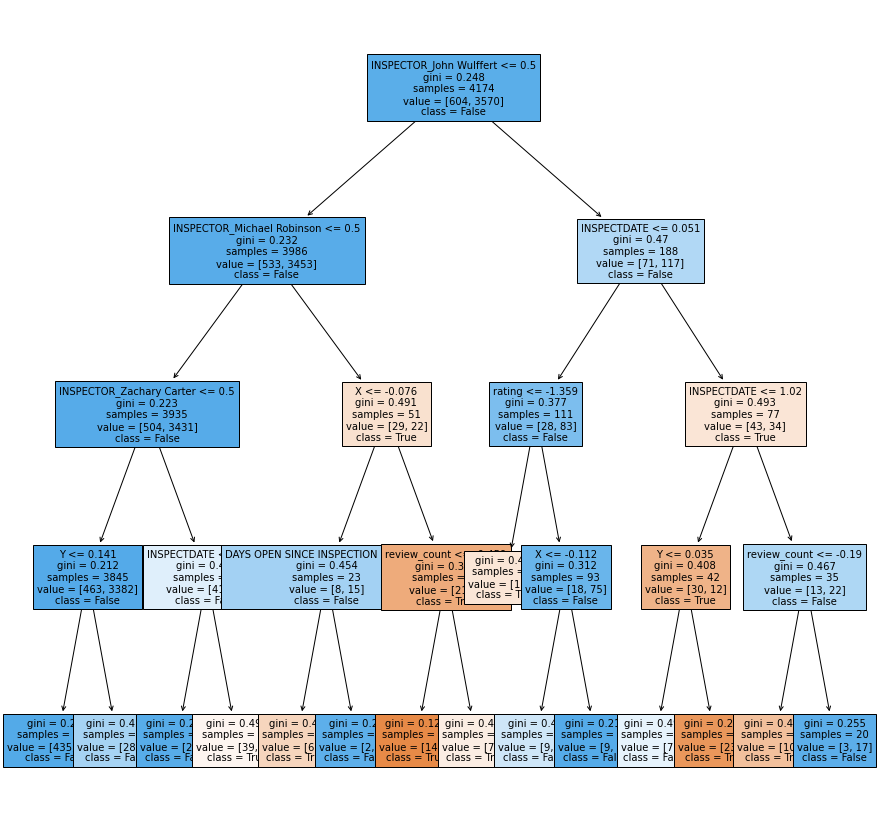

In [133]:
# decision tree
#Best pipeline: DecisionTreeClassifier(SelectPercentile(input_matrix, percentile=98), criterion=gini, max_depth=4, min_samples_leaf=10, min_samples_split=7)
#0.8553639846743295
from sklearn import tree
# Instantiate the decision tree model
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=10,  min_samples_split=7, random_state=0)

# Fit the tree to the data
tree_model.fit(X_train, y_train)

test_preds = tree_model.predict(X_test)
test_acc = np.sum(test_preds==y_test)/len(y_test)
print('Test set accuracy is {:.3f}'.format(test_acc))

# Visualize the decision tree
plt.figure(figsize=(15,15))
#tree.plot_tree(tree_model, fontsize=10)
plot_tree(tree_model,feature_names=X_train.columns,class_names=['True', 'False'],filled=True, fontsize=10)
#plot_tree(tree_model, feature_names=X_train.columns, class_names=y_train.unique(), filled=True)
plt.show()